In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../funcs/')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax

In [18]:
DATA_DIR = "../data/raw/proteomics/"
OUT_DIR = "../data/processed/061721"
PLOTS_DIR = "figures/data_processing"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"
SUBSET_LOCALIZED_SITES = True
KNN_NEIGHBORS = 5

cohort_final_names = {
    "MEDUL":"MB",
    "CCRCC":"ccRCC",
    "OV":"HGSC" 
}

In [23]:
cmap = {x.split("\t")[0]:x.split("\t")[1] for x in 
 
"""
GBM	#52b788
MB	#193e2e
HNSCC	#b7c47d
LSCC	#91bdff
LUAD	#1a759f
ccRCC	#ffd966
COAD	#ff8c69
PDAC	#962a13
UCEC	#5a189a
HGSC	#cdb4db
BRCA	#cd6090
""".strip().split("\n")
}

In [24]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)
samples_df = samples_df.dropna(subset=['RNA_Tumor'])[['cohort','Proteome_Sample_ID','RNA_Tumor']]
samples_df = samples_df.reset_index().set_index("RNA_Tumor").dropna()
samples = samples_df['participant_id']

samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0).loc[samples]
samples_df = samples_df[['cohort']].join(samples_df.iloc[:,1:].notna()).groupby('cohort').sum().T
samples_df.index = samples_df.index.str.replace("_Sample_ID","")
samples_df.index = samples_df.index.str.replace("_"," ")
samples_df = samples_df.loc[
    ["WXS","Germline WGS","RNA Tumor","Proteome","Phosphoproteome","Acetylome"],
    ['OV','BRCA','COAD','UCEC','PDAC','HNSCC','LUAD','LSCC','CCRCC','GBM','MEDUL']
]

samples_df = samples_df.rename(index={"RNA Tumor":"Transcriptome"})
samples_df = samples_df.rename(columns=cohort_final_names)

[None, None]

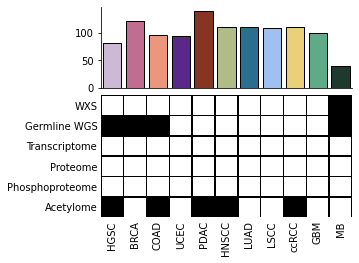

In [25]:
fig,ax = plt.subplots(figsize=(4.5,2.25))

sns.heatmap(
    data=samples_df,
    ax=ax,
    linewidth=0.5,
    linecolor='k',
    cmap='bone',
    vmax=1,
    cbar=False
)

x0 = ax.get_position().x0
x1 = ax.get_position().x1
y0 = ax.get_position().y0
y1 = ax.get_position().y1
buf = y1*0.05

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params('both', length=0)

dax = fig.add_axes([x0, y1+buf, x1-x0, 0.5])

sns.barplot(
    data=pd.DataFrame(samples_df.max(0)).loc[
        ['HGSC','BRCA','COAD','UCEC','PDAC','HNSCC','LUAD','LSCC','ccRCC','GBM','MB']].reset_index(),
    x='cohort',
    y=0, 
    linewidth=1, 
    edgecolor='k',
    ax=dax,
    palette=cmap,
)
dax.set_xticks([])
dax.set_xlabel("")
dax.set_ylabel("")
[dax.spines[x].set_visible(False) for x in ['top','right']]
plt.savefig(os.path.join(PLOTS_DIR, "1a_barchart.pdf"), dpi=200, bbox_inches='tight')

---

In [3]:
_order_full = ['CCRCC', 'COAD', 'HNSCC', 'OV', 'PDAC','BRCA','GBM','LSCC', 'LUAD', 'MEDUL','UCEC']
_order_acetyl = ['BRCA','GBM','LSCC', 'LUAD', 'MEDUL','UCEC']

features_df = pd.read_parquet("features_s.parquet")
pmap_df = pd.read_csv("../data/processed/061721/var_map_full.tsv", sep="\t",index_col=0)

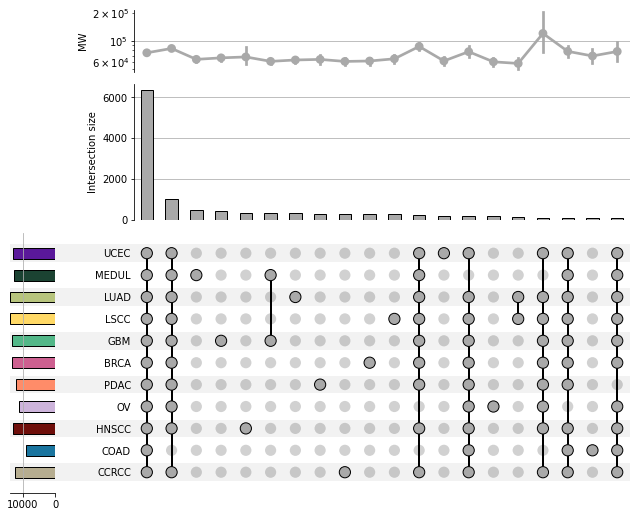

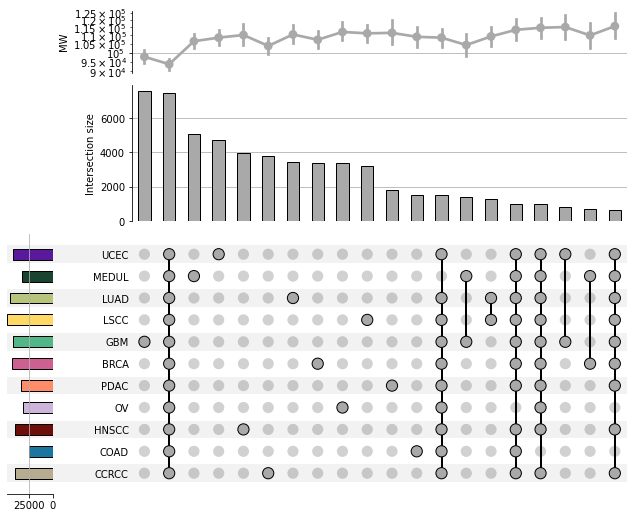

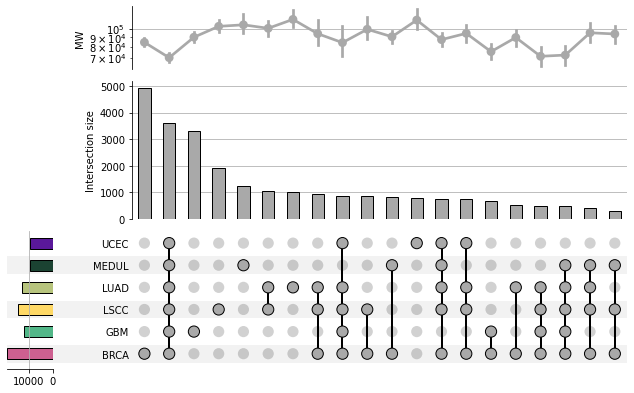

In [12]:
prot_f = pl.plot_prot_upset(features_df, 'proteome','Tumor', pmap_df=pmap_df, order=_order_full, ncols=20)
plt.savefig(os.path.join(PLOTS_DIR, "tumor_proteome_upset.pdf"), dpi=100, bbox_inches='tight')

phosph_f = pl.plot_prot_upset(features_df, 'phosphoproteome','Tumor', pmap_df=pmap_df, order=_order_full, ncols=20)
plt.savefig(os.path.join(PLOTS_DIR, "tumor_phosphoproteome_upset.pdf"), dpi=100, bbox_inches='tight')

acetyl_f = pl.plot_prot_upset(features_df, 'acetylome','Tumor', pmap_df=pmap_df, order=_order_acetyl, ncols=20)
plt.savefig(os.path.join(PLOTS_DIR, "tumor_acetylome_upset.pdf"), dpi=100, bbox_inches='tight')

In [4]:
## RNA Figure
rna_gene_map = pd.read_csv("../data/processed/061721/rna/var_map.tsv", sep='\t', index_col=0)
features_rna_df = pd.read_csv("../data/processed/061721/rna/ensg_by_cohort.tsv", sep='\t', index_col=0)
features_rna_df = features_rna_df.set_index('transcriptome').join(rna_gene_map).reset_index().rename(columns={'index':'transcriptome'})
features_rna_df['type'] = 'Tumor'

In [8]:
features_rna_df = features_rna_df[features_rna_df['biotype']!='TEC']

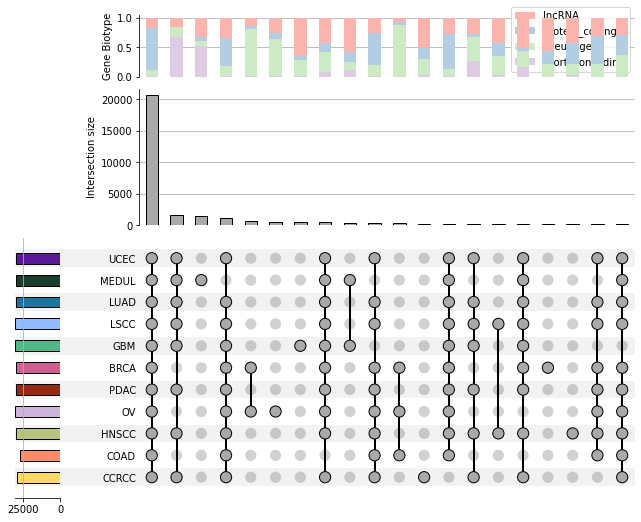

In [10]:
df = pl.plot_prot_upset(
    features_rna_df, 'transcriptome','Tumor', pmap_df=rna_gene_map, order=_order_full, ncols=20)

plt.savefig(os.path.join(PLOTS_DIR, "tumor_transcriptome_upset.pdf"), dpi=200, bbox_inches='tight')

---

In [51]:
def get_overlap_unique(df, cohorts):
    """
    Get overlap and uniques.
    """
    overlap_df = df.copy()
    unique = dict()
    
    for c in cohorts:
        overlap_df = overlap_df[overlap_df[c]]
        unique[c] = df[df[c]]
        
        for nc in cohorts:
            if nc != c:
                unique[c] = unique[c][unique[c][nc]==False]
    
    results_df = list()
    
    overlap_df = overlap_df[['MW','accession_number']]
    overlap_df['subset'] = 'overlap'
    results_df.append(overlap_df)
    
    for k in unique.keys():
        unique[k] = unique[k][['MW','accession_number']]
        unique[k]['subset'] = k
        results_df.append(unique[k])
        
    return pd.concat(results_df)

In [53]:
res_df = get_overlap_unique(df, _order_acetyl)

Text(0.5, 0, '')

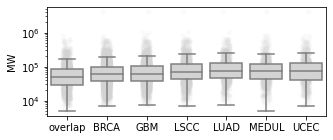

In [80]:
fig,ax = plt.subplots(figsize=(5,2))

sns.stripplot(
    data = res_df.drop_duplicates(subset=['accession_number','subset']),
    x='subset',
    y='MW',
    alpha=0.1,
    color='lightgrey',
    zorder=0
)

sns.boxplot(
    data = res_df.drop_duplicates(subset=['accession_number','subset']),
    x='subset',
    y='MW',
    fliersize=0,
    color='lightgrey'
)

ax.set_yscale('log')
ax.set_xlabel("")